In [5]:
import os
import json
import pandas as pd
from PIL import Image

In [55]:
_id = 95999
_id = f"{_id:012}"

In [56]:
_id

'000000095999'

In [58]:
_id = 95999
_id = f"{_id:012}"
anno = json.load(open("../data/annotations/{}.json".format(_id)))
image = Image.open("../data/images/train2017/{}.jpg".format(_id))

In [59]:
anno

{'file_name': '000000095999.jpg',
 'image_id': 95999,
 'box_category': [[[19.24, 156.09, 620.24, 144.55], 5],
  [[54.78, 275.5, 13.61, 7.5], 77],
  [[318.46, 285.77, 21.04, 36.26], 27],
  [[183.35, 309.93, 7.17, 27.01], 27],
  [[295.47, 289.93, 7.24, 23.18], 27],
  [[180.33, 385.48, 14.38, 18.68], 31],
  [[217.85, 272.63, 90.5, 154.37], 1],
  [[399.71, 282.25, 44.07, 114.64], 1],
  [[471.02, 262.52, 55.92, 136.9], 1],
  [[561.77, 257.85, 53.46, 134.49], 1],
  [[312.37, 268.42, 30.55, 107.23], 1],
  [[294.82, 271.94, 23.23, 101.16], 1],
  [[107.75, 298.07, 36.12, 128.93], 1],
  [[0.0, 235.52, 116.8, 191.48], 1],
  [[80.99, 264.3, 27.27, 33.07], 1],
  [[186.61, 266.65, 47.19, 126.99], 1],
  [[621.71, 274.75, 8.63, 30.47], 1],
  [[1.92, 249.72, 21.11, 30.71], 1],
  [[622.59, 281.09, 4.55, 7.2], 27],
  [[318.81, 287.08, 20.09, 33.93], 31],
  [[245.44, 283.44, 6.39, 4.42], 77],
  [[459.5, 264.77, 16.96, 75.05], 1],
  [[517.79, 287.35, 6.22, 12.77], 27],
  [[227, 260, 397, 82], 1]]}

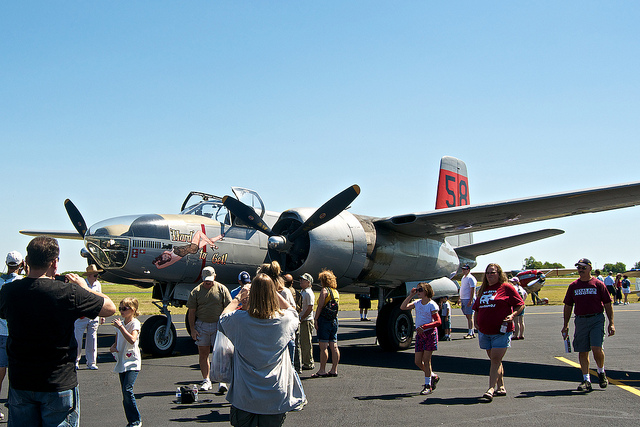

In [60]:
image

In [68]:
def crop_box(image, box):
    x,y,w,h = box
    return image.crop(box=[x,y,x+w,y+h])

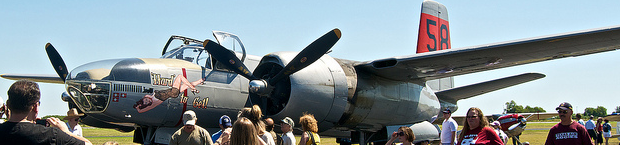

In [82]:
crop_box(image, anno['box_category'][0][0])

### Test Train script

In [1]:
import os
import numpy as np
from glob import glob
from PIL import Image
import json

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys

In [3]:
sys.path.append("/home/ubuntu/user-files/deepak.dhull/workspace/practice/faster-rcnn")

In [4]:
from config import Config
from model.detector import Detector
from model.utils import load_model_checkpoint, project_bboxes

# Dataset
class CocoDataset(Dataset):
    def __init__(self, image_id, config):
        self.config = config
        self.image_id = image_id
        
        # transforms
        self.transforms1 = torchvision.transforms.Compose([
            torchvision.transforms.PILToTensor(),
            torchvision.transforms.ConvertImageDtype(torch.float)
        ])
    
    def transform(self, image):
        image = self.transforms1(image)
        image /= 255
        return image
    
    def __getitem__(self, key):
        _id = self.image_id[key]
        image_path = os.path.join(self.config.image_dir, _id+'.jpg')
        annotation_path = os.path.join(self.config.annotation_dir, _id+'.json')
        image = Image.open(image_path)
        # get image height and width
        iwidth, iheight = image.size
        image = image.resize((self.config.image_size, self.config.image_size))
        
        box_category = json.load(open(annotation_path, 'r'))['box_category']
        def bbox_helper(l):
            box = l[0]
            x,y,w,h = box
            return [x,y,x+w,y+h]
        bbox = list(map(bbox_helper, box_category))
        area_threshold = 100
        areas_filter = list(map(lambda x: (x[0][2]*x[0][3])/(iwidth/self.config.image_size * iheight/self.config.image_size) >= area_threshold, box_category))
        # areas_filter = areas >= 40 
        bbox = torch.tensor(bbox)[areas_filter]
        
        # project bbox to resize image scale
        bbox = project_bboxes(
            bbox.unsqueeze(0), iwidth/self.config.image_size, iheight/self.config.image_size, mode='p2a'
        ).squeeze(0)
        
        k = max(0, self.config.max_bbox - bbox.shape[0])
        if k != 0:
            invalid_pad = torch.ones((k,4)) * -1
            bbox = torch.concat([bbox, invalid_pad])
        
        image = self.transform(image)
        
        if image.shape[0] == 1:
            # grey scale
            image = torch.concat([image, image, image], axis=0)
        
        return image, bbox

    def __len__(self):
        return len(self.image_id)

In [5]:
def create_dataset(config):
    images = glob(config.image_dir+"/*jpg")
    image_id = list(map(lambda x: x.rsplit("/",1)[-1].replace(".jpg",""), filter(lambda x: x.endswith('.jpg'),images)))
    train_image_id, val_image_id = train_test_split(image_id, train_size=0.8, random_state=32, shuffle=True)
    print(len(train_image_id), len(val_image_id))
    return train_image_id, val_image_id

In [6]:
train, val = create_dataset(Config)

94629 23658


In [7]:
ds = CocoDataset(train+val,Config)

In [8]:
ids = [532335, 371648, 408854, 480780]


In [9]:
# problem
532335

532335

In [10]:
idx = [ds.image_id.index(f"{i:012}") for i in ids]

In [11]:
image1, bbox1 = ds.__getitem__(idx[0])
image2, bbox2 = ds.__getitem__(idx[1])
image3, bbox3 = ds.__getitem__(idx[2])
image4, bbox4 = ds.__getitem__(idx[3])

In [12]:
torchvision.ops.box_area(bbox1)

tensor([ 6040.1753,  1484.7489,   262.9625,  3573.9285,  3590.8687, 55650.6992,
         1521.5735,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
            0.0000,     0.0000])

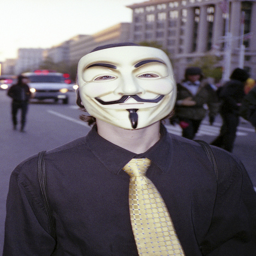

In [13]:
torchvision.transforms.ToPILImage()(image1*255)

In [14]:

def get_anchor_base(out_size, ratios, scales):
    # Need to optimize
    anc_x = torch.arange(out_size) + 0.5
    anc_y = torch.arange(out_size) + 0.5
    
    n_anchors = len(ratios) * len(scales)
    anc_base = torch.zeros((1, out_size, out_size, n_anchors, 4))
    for i,ix in enumerate(anc_x):
        for j,iy in enumerate(anc_y):
            anchor_box = torch.zeros(
                n_anchors, 4
            )
            c = 0
            for ratio in ratios:
                for scale in scales:
                    w = scale * ratio
                    h = scale
                    xmin = ix - w / 2
                    xmax = ix + w / 2
                    ymin = iy - h / 2
                    ymax = iy + h / 2
                    box = torch.tensor([xmin, ymin, xmax, ymax])
                    anchor_box[c, :] = box
                    c += 1
            
            anc_base[:, i, j, :, :] = torchvision.ops.clip_boxes_to_image(anchor_box, (out_size, out_size))
    return anc_base

In [ ]:
%%timeit
out_size = 368
ratios = [0.5, 1, 1.5]
scale = [2,4,6]
base = get_anchor_base(out_size, ratios, scale)

In [ ]:
base.shape

In [14]:
def get_model(config, device):
    
    detector = Detector(config)
    detector = load_model_checkpoint(detector, os.path.join(config.model_save_dir, f"{config.model_name}_{config.model_version}.pt"))
    return detector.to(device)

In [15]:
model = get_model(Config, torch.device("cpu"))

/home/ubuntu/miniconda3/envs/dev/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniconda3/envs/dev/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model.train(True)

Detector(
  (extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (rpn): RegionProposeNetwork(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv_cls): Conv2d(128, 9, kernel_size=(1, 1), stride=(1, 1))
    (conv_boxes): Conv2d(128, 36, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [17]:
optim = torch.optim.Adam(model.parameters())

In [18]:
_image = torch.concat([image1, image2, image3, image4]).view(-1, 3, 256, 256)
_bbox = torch.concat([bbox1, bbox2, bbox3, bbox4]).view(-1, 32, 4)

# _image = image1.unsqueeze(0)
# _bbox = bbox1.unsqueeze(0)

for i in range(1000):
    optim.zero_grad()
    prop, loss = model(_image, _bbox)
    print(i, loss.item())
    loss.backward()
    optim.step()
    break

base_anchor tensor(1.4403e+08)
gt_boxes tensor(8480.2939)
pred_pos_cls tensor(1193.5271, grad_fn=<SumBackward0>)
pred_offset tensor(45.3881, grad_fn=<SumBackward0>)
pred_neg_cls tensor(-5606.8604, grad_fn=<SumBackward0>)
proposals tensor(6610472., grad_fn=<SumBackward0>)
0 97.977783203125


In [19]:
1e3

1000.0

In [25]:
m = torch.tensor([0, 1, 1, 0, 1, 1]).float()

In [27]:
m[m == 0] = 1

In [28]:
m

tensor([1., 1., 1., 1., 1., 1.])

In [22]:
torch.log(torch.tensor([0, 1, 1, 0, 1, 1]))

tensor([-inf, 0., 0., -inf, 0., 0.])

In [27]:
for name, i in model.named_parameters():
    print(name)
    print(i.grad)
    print("*"*10)
    break

extractor.0.weight
tensor([[[[-4.7400e-03, -4.5392e-03, -4.4737e-03],
          [-4.6874e-03, -4.4226e-03, -4.3352e-03],
          [-4.7704e-03, -4.4814e-03, -4.3126e-03]],

         [[-4.7533e-03, -4.5458e-03, -4.3954e-03],
          [-4.7058e-03, -4.4426e-03, -4.2786e-03],
          [-4.7914e-03, -4.4973e-03, -4.2544e-03]],

         [[-4.4983e-03, -4.2603e-03, -4.0706e-03],
          [-4.4519e-03, -4.1776e-03, -3.9769e-03],
          [-4.5211e-03, -4.2207e-03, -3.9436e-03]]],


        [[[ 1.7924e-04,  1.3932e-04,  1.6736e-04],
          [ 3.2603e-04,  2.7036e-04,  2.6509e-04],
          [ 3.1299e-04,  2.3021e-04,  2.3974e-04]],

         [[ 8.0018e-05,  5.7403e-05,  1.1404e-04],
          [ 2.2616e-04,  1.9072e-04,  2.1379e-04],
          [ 2.2414e-04,  1.6383e-04,  1.9614e-04]],

         [[-6.8113e-06, -1.1938e-05,  6.6601e-05],
          [ 1.4190e-04,  1.2857e-04,  1.7851e-04],
          [ 1.5600e-04,  1.1948e-04,  1.7580e-04]]],


        [[[-3.2212e-03, -3.1876e-03, -3.2249e-0

In [27]:
loss.item()

54.243927001953125

In [31]:
model.state_dict().keys()

odict_keys(['extractor.0.weight', 'extractor.0.bias', 'extractor.2.weight', 'extractor.2.bias', 'extractor.5.weight', 'extractor.5.bias', 'extractor.7.weight', 'extractor.7.bias', 'rpn.conv.weight', 'rpn.conv.bias', 'rpn.conv_cls.weight', 'rpn.conv_cls.bias', 'rpn.conv_boxes.weight', 'rpn.conv_boxes.bias'])